In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

# 기본 구성

In [ ]:
# !pip install transformers
!pip install transformers==3.2

In [ ]:
pip install tensorflow-addons

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from tensorflow.keras.models import clone_model

from tqdm import tqdm
# from pororo import Pororo

# from keras import optimizers
from transformers import *
# from transformers import BertTokenizer, TFBertModel,PreTrainedTokenizerFast, TFBartModel
# from kobart_transformers import get_kobart_tokenizer, get_kobart_model

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences #tensorflow 전처리 모듈1
from tensorflow.keras.preprocessing.text import Tokenizer #tensorflow 전처리 모듈2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 그래프를 출력창에서 바로 볼 수 있게함
%matplotlib inline 


# BERT를 이용한 NEWS Topic 분류

### **Tokenizer code**




In [ ]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBERT model """


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer

logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {
    "vocab_file": "tokenizer_78b3253a26.model",
    "vocab_txt": "vocab.txt",
}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model",
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt",
    },
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512,
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False},
}

SPIECE_UNDERLINE = "▁"


class KoBertTokenizer(PreTrainedTokenizer):
    """
    SentencePiece based tokenizer. Peculiarities:
        - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
        self,
        vocab_file,
        vocab_txt,
        do_lower_case=False,
        remove_space=True,
        keep_accents=False,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        **kwargs,
    ):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs,
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, "r", encoding="utf-8") as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning(
                "You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                "pip install sentencepiece"
            )

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning(
                "You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                "pip install sentencepiece"
            )
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize("NFKD", outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text):
        """Tokenize a string."""
        text = self.preprocess_text(text)
        pieces = self.sp_model.encode(text, out_type=str)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(
                map(
                    lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0,
                    token_ids_0,
                )
            )

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """Save the sentencepiece vocabulary (copy original file) and special tokens file
        to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

## **전처리 실행 code Mecab 사용**

In [ ]:
#################
## Import DATA, submission file
train = pd.read_csv("/content/drive/MyDrive/augm_data/train_clean_4bert.csv", error_bad_lines=False  )
test = pd.read_csv("/content/drive/MyDrive/augm_data/test_clean_4bert.csv",error_bad_lines=False)
submission = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/sample_submission.csv",error_bad_lines=False)
topic_dict = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/topic_dict.csv",error_bad_lines=False)

In [ ]:
train

,Unnamed: 0,index,title,topic_idx,ko_to_en,en_to_ko,c_title,c_title_enko
0,0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,travelers' anger during the flight cancellatio...,인천 핀란드 항공편 취소 당시 여행자들의 분노,인천 핀란드 항공기 결항 휴가철 여행객 분통,인천 핀란드 항공편 취소 당시 여행자들의 분노
1,1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,I'll cross Silicon Valley. 15 trillion won in ...,나는 실리콘밸리를 건너갈 것이다 구글이 미국을 세계화하는 데 15조원이 투입됐다.,실리콘밸리 넘어서겠다 구글 number조원 들여 미국전역 거점화,나는 실리콘밸리를 건너갈 것이다 구글이 미국을 세계화하는 데 number조원이 투입됐다
2,2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,the solution to easing Iran's foreign tension ...,이란의 외국 긴장을 완화하기 위한 해법은 미국 경제전쟁을 중단하는 것이다.,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,이란의 외국 긴장을 완화하기 위한 해법은 미국 경제전쟁을 중단하는 것이다
3,3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,a combination of special relations with Korean...,NYT 클린턴과 가까운 한국 기업과의 특별한 관계가 결합된 것,nyt 클린턴 측근한국기업 특수관계 조명 공과 사 맞물려종합,nyt 클린턴과 가까운 한국 기업과의 특별한 관계가 결합된 것
4,4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,the hope for a quick settlement of the U.S.-Ch...,"시진핑 트럼프 국가주석과의 미,중 무역협상이 빠르게 타결될 수 있기를 희망한다.",시진핑 트럼프에 중미 무역협상 조속 타결 희망,시진핑 트럼프 국가주석과의 미 중 무역협상이 빠르게 타결될 수 있기를 희망한다
...,...,...,...,...,...,...,...,...
45649,45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,a partnership with KB Financial's U.S. IB Steel,KB금융의 미국 IB스틸과의 제휴,kb금융 미국 ib 스티펠과 제휴 선진국 시장 공략,kb금융의 미국 ib스틸과의 제휴
45650,45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,a review of postponement and closure of the op...,서울시교육청에서 새로운 코로나 개장 연기 및 폐쇄 심사,number보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토,서울시교육청에서 새로운 코로나 개장 연기 및 폐쇄 심사
45651,45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,an actual investment tournament for Kiwoom Sec...,게시판에서 열린 2020년 키움증권 실제 투자대회,게시판 키움증권 number 키움 영웅전 실전투자대회,게시판에서 열린 number년 키움증권 실제 투자대회
45652,45652,45652,답변하는 배기동 국립중앙박물관장,2,"Bae Ki-dong, head of the National Museum of Korea",배기동 국립중앙박물관장,답변하는 배기동 국립중앙박물관장,배기동 국립중앙박물관장


In [ ]:
train_1 = train[['topic_idx', 'c_title']]
train_2 = train[[ 'topic_idx', 'c_title_enko']]
train_2 = train_2.rename(columns={'c_title_enko':'c_title'})

In [ ]:
test

,index,clear_text,ko_to_en,en_to_ko,clear_ko,clear_ko_1
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,the operation of creator support spaces until ...,다음 달 2일까지 유튜브에서 크리에이터 지원 공간 운영,다음 유튜브 크리에이터 지원 공간 운영,유튜브 내달 일 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져 남부지방 옅은 황사,a pale yellow dust in the southern part of the...,아버지의 날이 맑아지면서 남부지방의 옅은 노란 먼지,아버지 맑다 남부 지방 옅다 노랗다 먼지,어버이날 맑 남부 지방 옅 황사
2,45656,내년부터 국가rd 평가 때 논문건수는 반영 않는다,"From next year, the number of papers will not ...",내년부터는 전국 RD 평가에 논문 수가 반영되지 않는다.,내년 전국 rd 평가 논문 수가 반영 않다,내년 국가 rd 평가 때 논문 건수 반영 않
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,"the gathering of Kim Myung-ja, the new preside...",김명자 신임 과학협의회 회장과 젊은 과학자들의 지혜 모임,김명자 신임 과학 협의 회장 젊다 과학자 지혜 모임,김명자 신임 과 총 회장 원로 젊 과학자 지혜
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,"the publication of two new novels, including g...","회색 작가 김동식, 양심 고백 등 두 편의 새 소설이 출간되었다.",회색 작가 동식 양심 고백 편의 소설 추다 되어다,회색 인간 작가 김동식 심 새 소설 집 출간
...,...,...,...,...,...,...
9126,54780,인천 오후 3시35분 대설주의보 눈 3 1cm 쌓여,"At 3:35 p.m. in Incheon, snowfall is 3.1cm.",인천 오후 3시 35분에는 눈이 3.1㎝에 달한다.,인천 오후,인천 오후 시분 대설주의보 눈 cm
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,a general assembly of sexual harassment offici...,노래방 성추행 관계자들의 불구속 집회,노래방 성추행 관계자 불구속 집회,노래방 지인 성추행 외교부 사무관 불 구속 입건 종합
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개,the first two photos of the Busan protest at t...,40년 전 부마항에서 부산시위를 벌인 첫 두 장의 사진,부마 부산 시위 벌이다 장의 사진,년 전 부마 항쟁 부산 시위 사진 점 최초 공개
9129,54783,게시판 아리랑tv 아프리카개발은행 총회 개회식 생중계,a live broadcast of the opening ceremony of th...,아리란티브 게시판에서 아프리카개발은행 총회 개회식 생중계,아리다 티브 게시판 아프리카 개발 은행 총회 개회 생중계,게시판 아리랑 tv 아프리카 개발은행 총회 개회식 생 중계


In [ ]:
test_1 = test[['clear_ko']]
test_2 = test[['clear_ko_1']]
test_2 = test_2.rename(columns={'clear_ko_1':'clear_ko'})

In [ ]:
test_2

,clear_ko
0,유튜브 내달 일 크리에이터 지원 공간 운영
1,어버이날 맑 남부 지방 옅 황사
2,내년 국가 rd 평가 때 논문 건수 반영 않
3,김명자 신임 과 총 회장 원로 젊 과학자 지혜
4,회색 인간 작가 김동식 심 새 소설 집 출간
...,...
9126,인천 오후 시분 대설주의보 눈 cm
9127,노래방 지인 성추행 외교부 사무관 불 구속 입건 종합
9128,년 전 부마 항쟁 부산 시위 사진 점 최초 공개
9129,게시판 아리랑 tv 아프리카 개발은행 총회 개회식 생 중계


In [ ]:
train_augm = pd.concat([train_1,train_2], ignore_index=True )
# test_augm = pd.concat([test_1,test_2], ignore_index=True )

In [ ]:
train_augm

,topic_idx,c_title
0,4,인천 핀란드 항공기 결항 휴가철 여행객 분통
1,4,실리콘밸리 넘어서겠다 구글 number조원 들여 미국전역 거점화
2,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,4,nyt 클린턴 측근한국기업 특수관계 조명 공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망
...,...,...
91303,1,kb금융의 미국 ib스틸과의 제휴
91304,2,서울시교육청에서 새로운 코로나 개장 연기 및 폐쇄 심사
91305,1,게시판에서 열린 number년 키움증권 실제 투자대회
91306,2,배기동 국립중앙박물관장


In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

Text(0, 0.5, 'Probability')

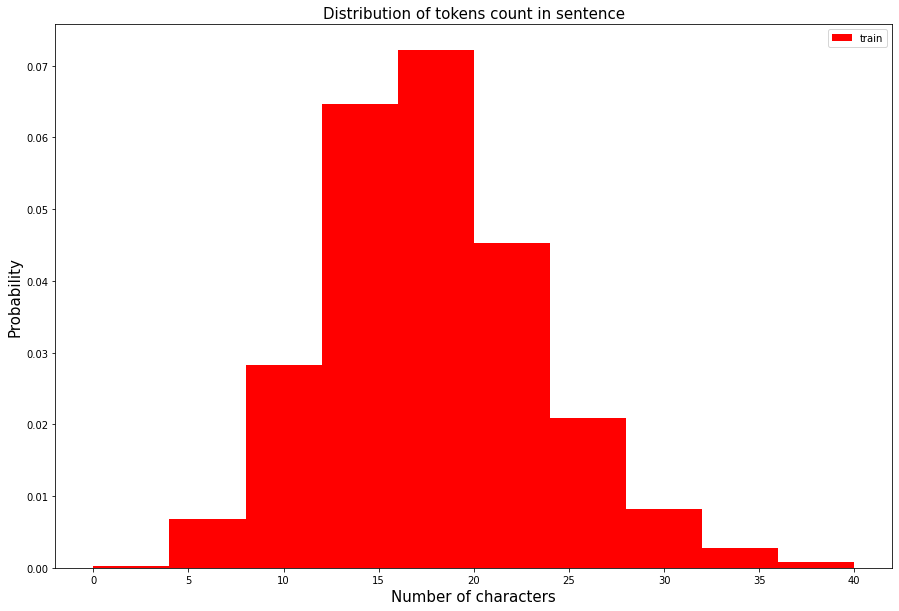

In [ ]:
# 각 문장을 BertTokenizer를 통해 하위 토큰으로 분류한 개수를 분석
train_bert_token_counts = train_augm['c_title'].apply(lambda x : len(tokenizer.tokenize(x)))

plt.figure(figsize=(15,10))
plt.hist(train_bert_token_counts, range=[0,40],density=True, facecolor='r',  label='train')
plt.title('Distribution of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [ ]:
print('문장 tokens 개수 최댓값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최댓값: 55
문장 tokens 개수 평균값: 17.26
문장 tokens 개수 표준편차: 5.64
문장 tokens 개수 중간값: 17.0
문장 tokens 개수 제 1사분위: 13.0
문장 tokens 개수 제 3사분위: 21.0
문장 tokens 개수 99퍼센트: 33.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f8f73844550>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8f73844890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8f73855ad0>],
 'means': [<matplotlib.lines.Line2D at 0x7f8f7384b850>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8f7384b310>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8f73896c10>,
  <matplotlib.lines.Line2D at 0x7f8f73844fd0>]}

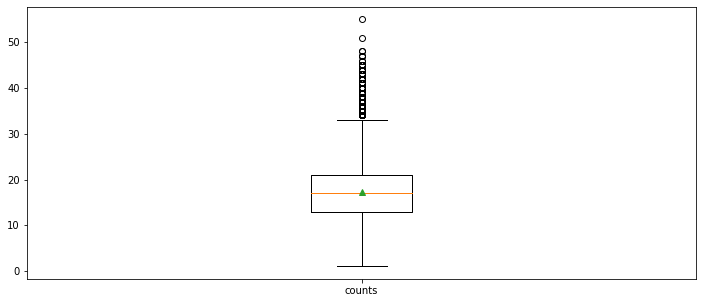

In [ ]:
# 데이터의 길이를 나타내는 Boxplot
plt.figure(figsize=(12, 5))

plt.boxplot(
            train_bert_token_counts, 
            labels=['counts'], 
            showmeans=True
            )

In [ ]:
model_name = 'monologg/kobert'
SEED_NUM = 977
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)
BATCH_SIZE = 256
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = 36
NUM_CLASS = 7
K_SPLIT = 3
# 이상치 데이터로인해 평균이 급격히 올라갈수 있기에 EDA분석을 통해 적절히 정해야함 평균값이던 중간값이던 3사분위 값이던
# EDA를 통해 이상치 데이터가 없으면 최대값이용

In [ ]:


# BERT에 필요한 입력값은 총 3개
# input_ids : 문장을 tokenize해서 index로 변환
# attention_mask : 1은 attention에 영향을 받음, 0은 영향을 받지 않음
# token_type_ids : 0과 1로 문장의 토큰 값을 분리

# special token 역할
# [UNK] : 모르는 단어에 대한 token
# [MASK] : 마스크 token, 사전학습(Pre-training)에서 활용
# [PAD] : 최대 길이를 맞추는 용도
# [SEP] : 문장의 종결을 알림
# [CLS] : 문장의 시작을 알림

def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        
        text = sent,
        add_special_tokens = True, # True : 토큰 시작점에 [CLS] 토큰과 토큰의 마지막에 [SEP]토큰을 붙임
        max_length = MAX_LEN, # MAX_LEN 최대 길이에 따라 문장의 길이를 맞추는 작업을 진행 ; MAX_LEN보다 길면 truncate
        pad_to_max_length = True, # True : MAX_LEN의 길이에 미치지 못하는 문장에 padding을 적용 **padding : 길이를 일괄적으로 맞춰주는 것
                                                     # 각 데이터의 길이가 다를경우 모델에 적용할 수 없음 그렇기에 padding진행
                                         
        return_attention_mask = True, # True : BERT에 필요한 입력값 중 attention_mask를 생성
        truncation = True 
        # encoded_plus 과정 중 token_type으로 문장이 1개면 0, 문장이 2개면 0과 1로 구분
    )


    input_id = encoded_dict['input_ids'] # BERT 입력값 중 하나인 input_ids
    attention_mask = encoded_dict['attention_mask'] # attention_mask ; 단순히 padding과 non-padding을 구분
    token_type_id = encoded_dict['token_type_ids'] # 두개의 문장 구분용


    return input_id, attention_mask, token_type_id # 각각의 BERT 입력값들을 encoded_dict를 한 결과를 return

In [ ]:
print(tokenizer.all_special_tokens) # BERT special tokens
print(tokenizer.all_special_ids)  # BERT special tokens의 index

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[0, 3, 1, 2, 4]


In [ ]:
train_augm

,topic_idx,c_title
0,4,인천 핀란드 항공기 결항 휴가철 여행객 분통
1,4,실리콘밸리 넘어서겠다 구글 number조원 들여 미국전역 거점화
2,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,4,nyt 클린턴 측근한국기업 특수관계 조명 공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망
...,...,...
91303,1,kb금융의 미국 ib스틸과의 제휴
91304,2,서울시교육청에서 새로운 코로나 개장 연기 및 폐쇄 심사
91305,1,게시판에서 열린 number년 키움증권 실제 투자대회
91306,2,배기동 국립중앙박물관장


In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_augm, train_augm["topic_idx"], 
                                                            random_state=42, test_size=0.2)

In [ ]:
train_inputs

,topic_idx,c_title
26945,1,큐로홀딩스 number억원 규모 number자배정 유상증자
47240,3,봄꽃을 보러 한국에 온다 홍콩으로의 관광객 유치 속도
79533,0,삼성sds홈iot의 스마트 월드패드 개발
6682,1,인공지능 a생명 달러 강세 전망에 달러보험 판매 급증
20285,5,축구 스타 출신 호나우지뉴 정계 진출 우파 정당서 영입 추진
...,...,...
6265,4,런던지하철 number월부터 number시간 운행 런던시장 야간경제 활성화
54886,3,충북 오후부터 유명한 산과 놀이공원인 한산
76820,6,봉하마을의 김부겸 의원의 게스트북
860,6,천정배박주선 정동영 포함 number자 연대 추진 합의종합


In [ ]:
for i in train_labels:
    print(i)
    break

1


In [ ]:

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for train_sent, train_label in tqdm(zip(train_inputs["c_title"], train_labels)): 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass


train_news_input_ids = np.array(input_ids, dtype=int)
train_news_attention_masks = np.array(attention_masks, dtype=int)
train_news_type_ids = np.array(token_type_ids, dtype=int)

# 최종 출력값은 numpy로 변환한 후 tuple 형태로 묶어서 저장
train_news_inputs = (train_news_input_ids, train_news_attention_masks, train_news_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) # 정답 tokenizing 리스트


In [ ]:

valid_input_ids = []
valid_attention_masks = []
valid_token_type_ids = []
valid_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for train_sent, train_label in tqdm(zip(validation_inputs["c_title"], validation_labels)): 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        valid_input_ids.append(input_id)
        valid_attention_masks.append(attention_mask)
        valid_token_type_ids.append(token_type_id)
        valid_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass


valid_news_input_ids = np.array(valid_input_ids, dtype=int)
valid_news_attention_masks = np.array(valid_attention_masks, dtype=int)
valid_news_type_ids = np.array(valid_token_type_ids, dtype=int)

# 최종 출력값은 numpy로 변환한 후 tuple 형태로 묶어서 저장
valid_news_inputs = (valid_news_input_ids, valid_news_attention_masks, valid_news_type_ids)

valid_data_labels = np.asarray(valid_data_labels, dtype=np.int32) # 정답 tokenizing 리스트


In [ ]:
# bert_tokenizer를 통해 실제결과가 나오는지 테스트
INPUT_id = train_news_input_ids[30]
ATTENTION_mask = train_news_attention_masks[30]
TOKEN_TYPE_id = train_news_type_ids[30]

print(INPUT_id)
print(ATTENTION_mask)
print(TOKEN_TYPE_id)
print(tokenizer.decode(INPUT_id))

In [ ]:
class TFBertClassifier(tf.keras.Model): # pre_trained된 bert model을 불러와 그 위에 완전연결층 1층을 쌓은 구조
                                                              # class로 모델을 구현하려면 tf.keras.Model을 상속받아야 함
    # TFBertClassifier생성할 때마다 __init__실행                                                          
    def __init__(self, model_name, dir_path, num_class): # model_name : 인자로 받아 활용할 모델 이름, dir_path : 모델이 저장된 위치
                                                                                            # num_class : 원하는 정답의 개수(감성분석인 경우 2; 긍정, 부정)
        # super함수를 통해 부모 클래스(tf.keras.Model)에 있는 __init__함수 호출   
        # tf.keras.Model 클래스를 상속받는 경우 super함수를 통해 부모 클래스에 __init__ 함수의 인자에 모델이름을 전달하면
        # tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름으로 공통적으로 사용
        super(TFBertClassifier, self).__init__()

         
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True) # 기존에 pre_trained 한 부분이 로드됨
                                                                                                                                    
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob) # 과적합을 방지하기 위한 layer
        # self.classifier을 통해 topic_idx를 전부 분류
        self.classifier = tf.keras.layers.Dense(num_class,
                                                                    kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                                    name="classifier")  # 완전연결층 1층

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False): 
        #__init__에서 선언한 내용을 실제 입력을 받고 실행하는 call 메서드임
        # call함수를 호출하면 입력한 inputs을 통해 마지막에 예측값을 출력
        # 영화 리뷰 text를 inputs을 통해 받음
        # output 값 : sequence_output, pooled_output, (hidden_states), (attentions)
        # sequence_output : sequence 길이의 출력을 모두 입력으로 받음; 이 벡터의 차원 ' 임베딩 크기 * 최대문장길이'
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids) # bert를 통해 outputs로 결과값을 추출
        pooled_output = outputs[1] # pooled_output
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output) # self.classifier를 통해 완전연결층을 활용하여 최종적으로 self.num_labels 개수에 맞는 예측값을 출력
        return logits

cls_model= TFBertClassifier(model_name=model_name,
                                                dir_path='bert_ckpt', # ???
                                                num_class=NUM_CLASS) # num_class 바꿔야함



### Adam최적화와 손실값, 모델 정확도 정의

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=10e-5, decay=1e-5)
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=5.0e-5, total_steps = 2344*4, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer,
                                loss=loss,
                                metrics=[metric])

In [ ]:
# 모델이 어느 시점이 되면 학습평가점수는 높아지는데 검증평가 점수가 낮아지는 overfitting현상이 발생하거나
# 학습도중 특정 상태의 모델에서 하이퍼파라미터를 바꿔서 다시 학습을 진행할 수도 있음
# => tensowflow.keras.callback 모듈의 EarlyStopping, ModelCheckpoint 클래스를 활용하여 해결


# 특정 epoch에서 현재 검증 평가 점수가 이전 검증 평가 점수보다 일정수치 미만으로 낮아지면 학습을 멈추는 역할
# 학습 중 overfitting을 방지한다는 것
es_callback = EarlyStopping(
                                monitor='val_loss', # 'val_accuracy'를 통해 검증 평가 점수로 활용한다는 것
                                mode='min',
                                min_delta=0.0001, # 활용한 평가 점수에 따라 현재 점수가 이전 점수에 비해 0.0001 보다 낮아지면 overfitting현상이 발생한다고 생각하고 학습을 멈춤
                                patience=5,
                                baseline=0.4
                                 ) # 검증 평가 점수가 이전 최고 점수보다 높아지지 않는 epoch수가 patience에 입력한 횟수를 넘어가면 학습을 멈춤

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)



DATA_OUT_PATH = '/content/drive/MyDrive/best_model'
# 오류시 DATA_OUT_PATH = '/content/gdrive/MyDrive/bert_data_out'

checkpoint_path = DATA_OUT_PATH +  '/best_modeling.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

# Epoch마다 모델을 저장하게끔 함(학습중 모델을 저장한다는 것)    
cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', # save_best_only를 하는 평가기준
    verbose=1, 
    save_best_only=True, # True : 가장 성능이 좋은 모델만 저장한다는 것
    save_weights_only=True # True : 모델 그래프를 전부 저장하는 것이 아닌 모델 가중치만 저장한다는 것
    )


/content/drive/MyDrive/best_model -- Folder already exists 



In [ ]:

# 학습과 eval 시작
history = cls_model.fit(train_news_inputs, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split = VALID_SPLIT, # 학습데이터에서 일정한 비율로 무작위로 나눔
                        callbacks=[es_callback, cp_callback]
                        ) # 검증데이터셋이 있을경우 파라미터로 validation_data = 로 데이터셋을 지정한 다음 validation_split파라미터를 지운다.

Epoch 1/10
229/229 [==============================] - 298s 1s/step - loss: 1.8205 - accuracy: 0.2827 - val_loss: 1.0566 - val_accuracy: 0.7864

Epoch 00001: val_loss improved from inf to 1.05664, saving model to /content/drive/MyDrive/best_model/best_modeling.ckpt
Epoch 2/10
229/229 [==============================] - 244s 1s/step - loss: 0.5926 - accuracy: 0.8336 - val_loss: 0.4231 - val_accuracy: 0.8617

Epoch 00002: val_loss improved from 1.05664 to 0.42313, saving model to /content/drive/MyDrive/best_model/best_modeling.ckpt
Epoch 3/10
229/229 [==============================] - 244s 1s/step - loss: 0.3963 - accuracy: 0.8701 - val_loss: 0.3813 - val_accuracy: 0.8726

Epoch 00003: val_loss improved from 0.42313 to 0.38130, saving model to /content/drive/MyDrive/best_model/best_modeling.ckpt
Epoch 4/10
229/229 [==============================] - 244s 1s/step - loss: 0.3382 - accuracy: 0.8862 - val_loss: 0.3647 - val_accuracy: 0.8772

Epoch 00004: val_loss improved from 0.38130 to 0.3646

In [ ]:
score = cls_model.evaluate(valid_news_inputs, valid_data_labels, batch_size=128)

143/143 [==============================] - 24s 170ms/step - loss: 0.4616 - accuracy: 0.8850


In [ ]:
print('valid loss:{:.5f} / valid acc:{:.5f}'.format(score[0], score[1]))

valid loss:0.46162 / valid acc:0.88495


## 모델 Test

In [ ]:


input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for test_sent in test["c_title"]: 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        
    except Exception as e:
        print(e)
        print(test_sent)
        pass


test_news_input_ids = np.array(input_ids, dtype=int)
test_news_attention_masks = np.array(attention_masks, dtype=int)
test_news_type_ids = np.array(token_type_ids, dtype=int)

test_news_inputs = (test_news_input_ids, test_news_attention_masks, test_news_type_ids)




/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# model.load_weights(checkpoint_filepath)
cls_model_1 = TFBertClassifier(model_name=model_name,
                                                dir_path='bert_ckpt', # ???
                                                num_class=NUM_CLASS) # num_class 바꿔야함
cls_model_1.load_weights(os.path.join(DATA_OUT_PATH,'best_modeling.ckpt')) # 오류시 '/weight.h5'



All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
valid_predictions = cls_model.predict(valid_news_inputs)
true = [label for label in valid_data_labels]


In [ ]:
flat_valid = np.argmax(valid_predictions, axis = 1)
flat_valid

array([3, 6, 2, ..., 1, 5, 6])

In [ ]:

predictions = cls_model_1.predict(test_news_inputs)
pred = np.argmax(predictions, axis = 1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_valid, true))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1958
           1       0.85      0.85      0.85      2482
           2       0.79      0.81      0.80      2918
           3       0.92      0.87      0.89      2490
           4       0.91      0.94      0.92      2905
           5       0.97      0.95      0.96      2855
           6       0.91      0.92      0.91      2654

    accuracy                           0.88     18262
   macro avg       0.88      0.88      0.88     18262
weighted avg       0.89      0.88      0.89     18262



In [ ]:
flat_valid_1 = np.argmax(valid_predictions, axis = 1).flatten()
crosstab = pd.crosstab(valid_data_labels, flat_valid_1, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,2,3,4,5,6
real,,,,,,,
0,1668,146,102,46,14,13,0
1,116,2099,157,26,32,15,13
2,102,175,2355,164,44,32,112
3,25,21,107,2175,24,14,10
4,29,26,41,44,2728,62,77
5,8,5,19,22,7,2706,12
6,10,10,137,13,56,13,2430


In [ ]:
pred

array([2, 3, 2, ..., 3, 2, 6])

In [ ]:
submission_1 = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/sample_submission.csv",error_bad_lines=False)

In [ ]:
import torch.nn.functional as F
import torch

In [ ]:
z = torch.FloatTensor(predictions)
probs_1 = F.softmax(z, dim=1)
probs_1 = (probs_1).tolist()

In [ ]:

a, b, c, d, e, f, g = [], [] ,[] ,[] ,[] ,[] ,[]
for row in probs_1:
    a.append(row[0])
    b.append(row[1])
    c.append(row[2])
    d.append(row[3])
    e.append(row[4])
    f.append(row[5])
    g.append(row[6])

submission_1['0'] = a
submission_1['1'] = b
submission_1['2'] = c
submission_1['3'] = d
submission_1['4'] = e
submission_1['5'] = f
submission_1['6'] = g

submission_1.topic_idx = pred
submission.topic_idx = pred

In [ ]:
submission_1

,index,topic_idx,0,1,2,3,4,5,6
0,45654,2,0.215041,0.016211,0.406379,0.357896,0.001104,0.001923,0.001446
1,45655,3,0.000634,0.000404,0.011925,0.984652,0.000418,0.000907,0.001062
2,45656,2,0.003131,0.003214,0.977291,0.003675,0.000567,0.000496,0.011626
3,45657,2,0.180473,0.005235,0.749717,0.005749,0.004177,0.000999,0.053652
4,45658,3,0.000519,0.000657,0.004605,0.992992,0.000344,0.000429,0.000454
...,...,...,...,...,...,...,...,...,...
9126,54780,3,0.000755,0.000458,0.024616,0.971422,0.000589,0.000981,0.001178
9127,54781,2,0.001294,0.001153,0.870385,0.001993,0.015376,0.000716,0.109082
9128,54782,3,0.002520,0.003682,0.291404,0.696688,0.001650,0.001489,0.002569
9129,54783,2,0.144090,0.005499,0.798480,0.042268,0.001033,0.001100,0.007530


In [ ]:
submission

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,3
9129,54783,2


In [ ]:
submission_1.to_csv('Kobert_Radam.csv',index = False)
submission.to_csv('KoBERT_Radam.csv',index = False)

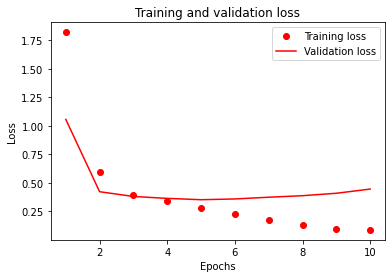

In [ ]:


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

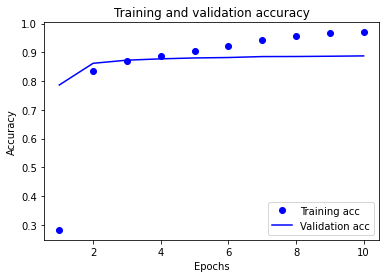

In [ ]:
plt.clf()   # 초기화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
!pip install /content/drive/MyDrive/DACON/dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./drive/MyDrive/DACON/dacon_submit_api-0.0.4-py3-none-any.whl


In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'KoBERT_Radam.csv', # 파일경로
'e6ebfea66ef322fcfc88d1d2985d55d8c676a5635701ea26a20cd1d1f5a6ac9f',  # 개인토큰
'235747', # 대회 id
'Healthy Guys',  # 팀이름
'KoBERT_Radam') # 노트

{'isSubmitted': True, 'detail': 'Success'}
